## Importation des Modules

In [1]:
cd /Users/macbookpro/Desktop/MLOPS_Project

/Users/macbookpro/Desktop/MLOPS_Project


In [98]:
%reload_ext autoreload
%autoreload 2

import sys
from pathlib import Path

import cv2
import os
import numpy as np
from collections import Counter
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import pendulum
from loguru import logger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.utils import shuffle
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from ydata_profiling import ProfileReport
from sklearn.preprocessing import LabelBinarizer

from src.make_dataset import *
from src.make_model import *

## Settings

In [45]:
# Set logging format
log_fmt = "<green>{time:YYYY-MM-DD HH:mm:ss.SSS!UTC}</green> | <level>{level: <8}</level> | <cyan>{name}</cyan>:<cyan>{function}</cyan>:<cyan>{line}</cyan> - {message}"
logger.configure(handlers=[{"sink": sys.stderr, "format": log_fmt}])

# current data
CURRENT_DATE = pendulum.now(tz="UTC")

# directories
PROJECT_DIR = Path.cwd().parent
REPORTS_DIR = Path(PROJECT_DIR, "reports")

logger.info(f"\nProject directory: {PROJECT_DIR} \nReports dir: {REPORTS_DIR}")

2024-08-03 16:15:44.955 | INFO     | __main__:<module>:12 - 
Project directory: /Users/macbookpro/Desktop 
Reports dir: /Users/macbookpro/Desktop/reports


## Load Data

In [61]:
base_dir = '/Users/macbookpro/Desktop/Garbage classification/archive/Garbage classification/Garbage_classification'

In [62]:
imgs_data,labels_data, class_names = load_data(base_dir)

Loading plastic: 100%|██████████████████████| 482/482 [00:00<00:00, 1279.52it/s]


## Vizualisation & Preprocessing

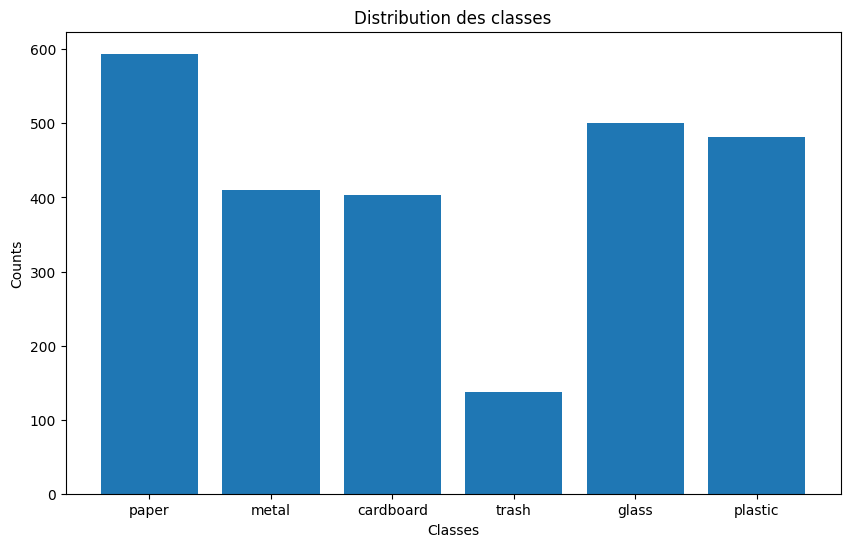

In [39]:
visualize_class_distribution(labels_data, class_names)

Images de: paper


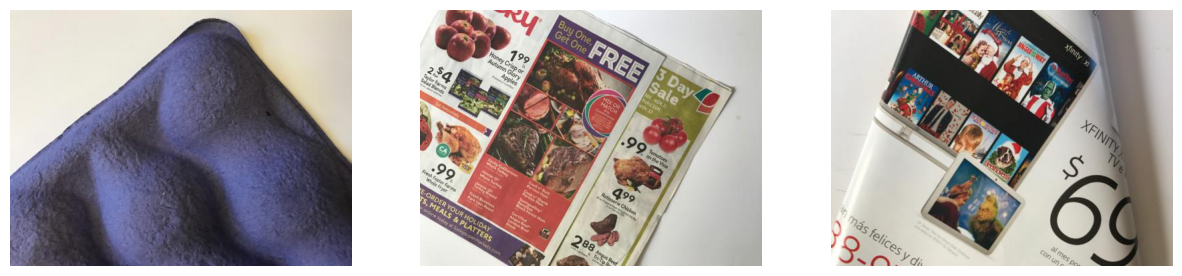

Images de: metal


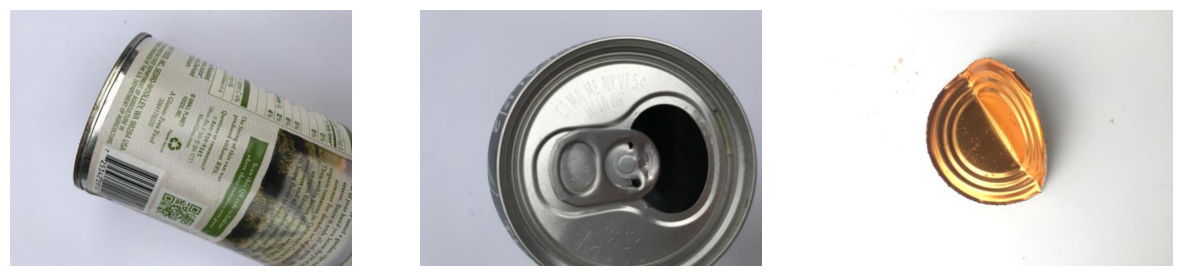

Images de: cardboard


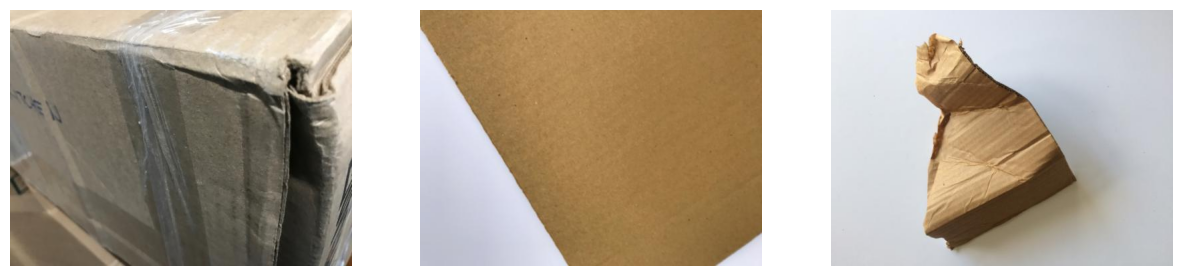

Images de: trash


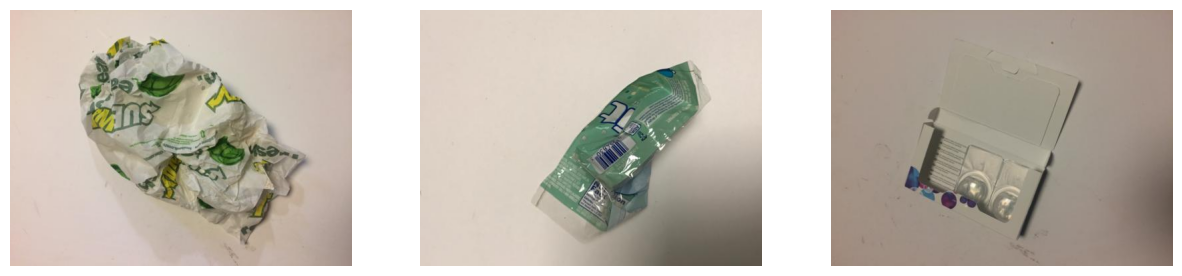

Images de: glass


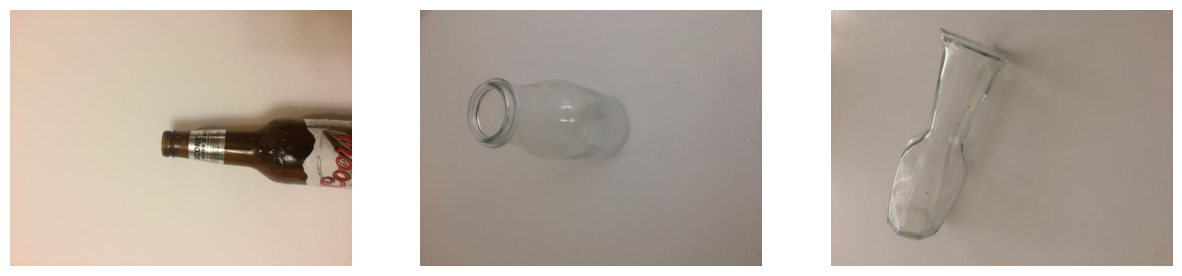

Images de: plastic


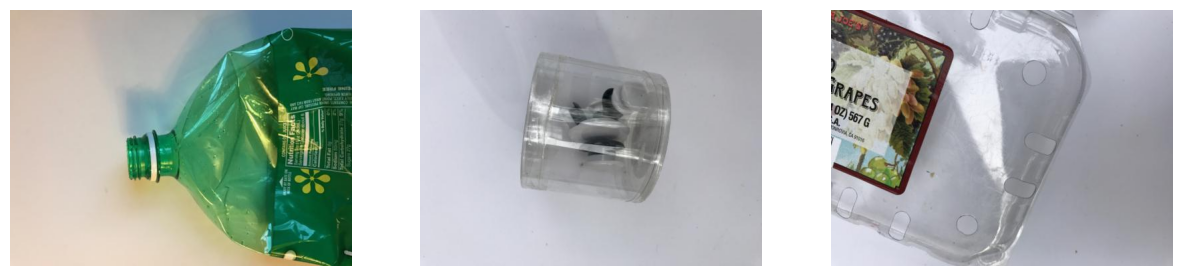

In [63]:
plot_images_from_subfolders(base_dir)

In [75]:
img_dimensions(base_dir)

Analyse des images en: /Users/macbookpro/Desktop/Garbage classification/archive/Garbage classification/Garbage_classification/paper
Dimensions les plus courantes:
Dimension (hauteur x largeur): (384, 512), Fréquence: 594


Analyse des images en: /Users/macbookpro/Desktop/Garbage classification/archive/Garbage classification/Garbage_classification/metal
Dimensions les plus courantes:
Dimension (hauteur x largeur): (384, 512), Fréquence: 410


Analyse des images en: /Users/macbookpro/Desktop/Garbage classification/archive/Garbage classification/Garbage_classification/cardboard
Dimensions les plus courantes:
Dimension (hauteur x largeur): (384, 512), Fréquence: 403


Analyse des images en: /Users/macbookpro/Desktop/Garbage classification/archive/Garbage classification/Garbage_classification/trash
Dimensions les plus courantes:
Dimension (hauteur x largeur): (384, 512), Fréquence: 137


Analyse des images en: /Users/macbookpro/Desktop/Garbage classification/archive/Garbage classification/G

In [79]:
processed_dir = "/Users/macbookpro/Desktop/Garbage classification/archive/Garbage classification/processed_images"
data, labels = process_dataset(base_dir, processed_dir)

Classe cardboard : 403 processed
Classe glass : 501 processed
Classe metal : 410 processed
Classe paper : 594 processed
Classe plastic : 482 processed
Classe trash : 137 processed


In [80]:
img_dimensions(processed_dir)

Analyse des images en: /Users/macbookpro/Desktop/Garbage classification/archive/Garbage classification/processed_images/paper
Dimensions les plus courantes:
Dimension (hauteur x largeur): (128, 128), Fréquence: 594


Analyse des images en: /Users/macbookpro/Desktop/Garbage classification/archive/Garbage classification/processed_images/metal
Dimensions les plus courantes:
Dimension (hauteur x largeur): (128, 128), Fréquence: 410


Analyse des images en: /Users/macbookpro/Desktop/Garbage classification/archive/Garbage classification/processed_images/cardboard
Dimensions les plus courantes:
Dimension (hauteur x largeur): (128, 128), Fréquence: 403


Analyse des images en: /Users/macbookpro/Desktop/Garbage classification/archive/Garbage classification/processed_images/trash
Dimensions les plus courantes:
Dimension (hauteur x largeur): (128, 128), Fréquence: 137


Analyse des images en: /Users/macbookpro/Desktop/Garbage classification/archive/Garbage classification/processed_images/glass
Di

Images de: paper


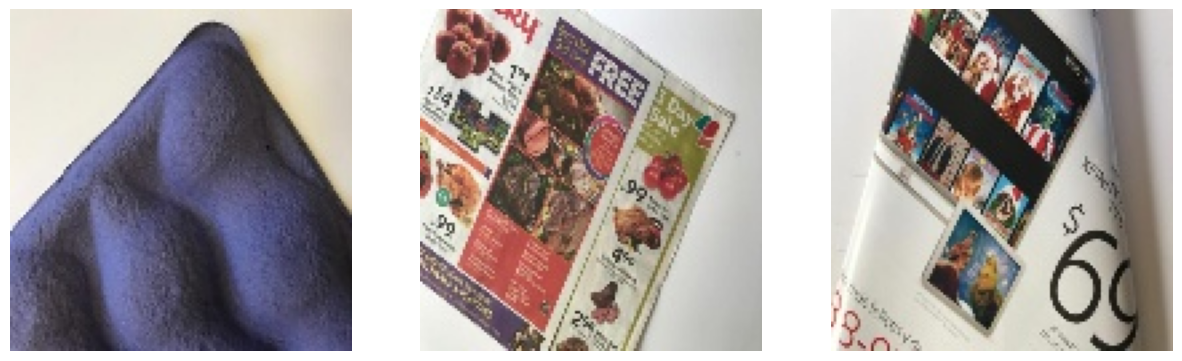

Images de: metal


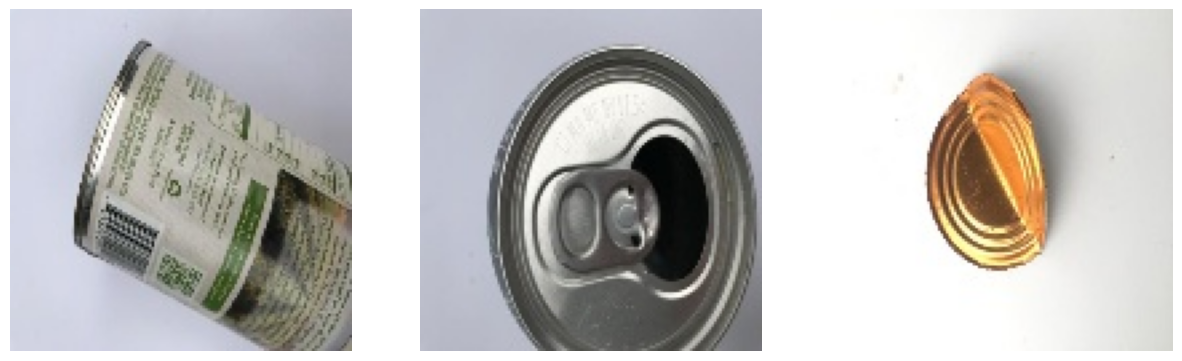

Images de: cardboard


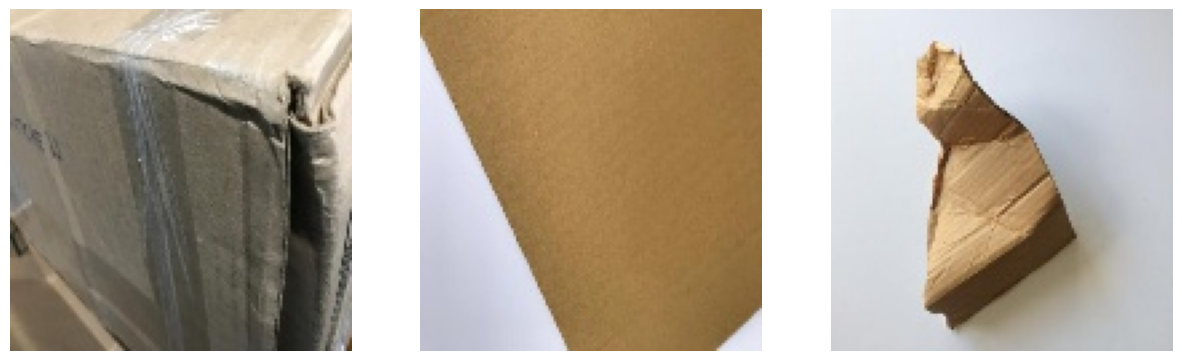

Images de: trash


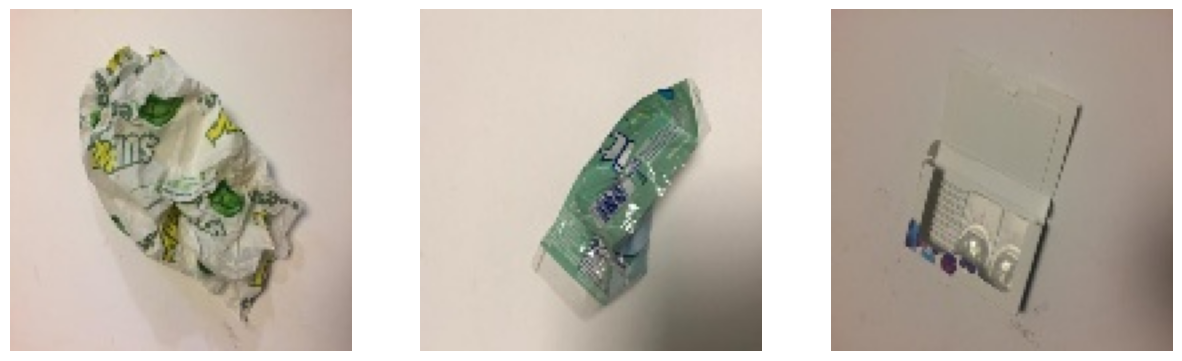

Images de: glass


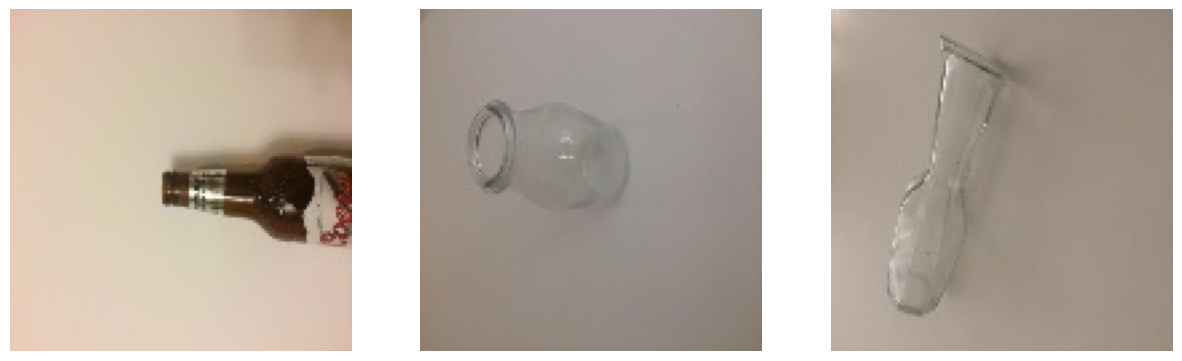

Images de: plastic


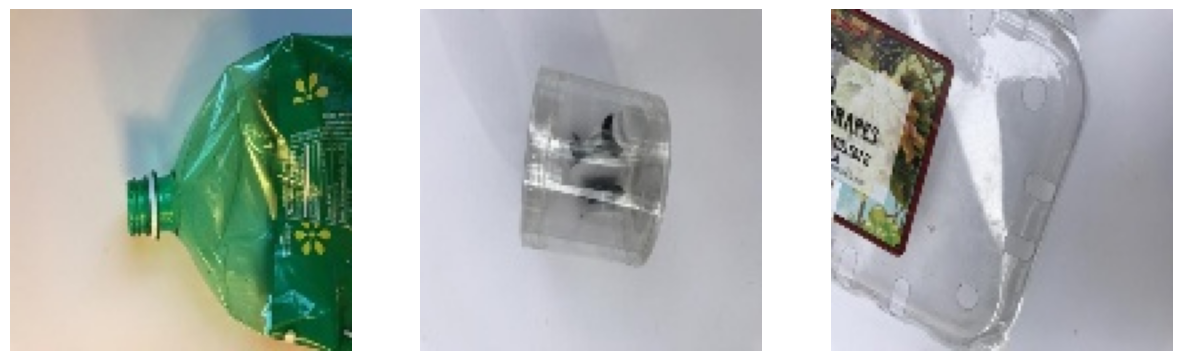

In [86]:
plot_images_from_subfolders(processed_dir)

### Normalization & Encoding

In [85]:
# Convertit la liste data en un tableau NumPy.
# Spécifie le type de données comme "float32" pour la précision et l'efficacité
# Divise toutes les valeurs par 255.0, normalisant ainsi les pixels dans la plage [0, 1]
data = np.array(data, dtype="float32") / 255.0
#Convertit la liste labels en un tableau NumPy pour un traitement ultérieur efficace.
labels = np.array(labels)
# Crée une instance de LabelBinarizer de scikit-learn qui va encoder les étiquettes textuelles en format numérique
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
#Affiche la première étiquette encodée pour vérification.
print(labels[0])

[1 0 0 0 0 0]


## Apply augmentation to the dataset

In [92]:
final_imgs_data, final_labels_data = increase_dataset(data, labels)

In [93]:
print("Size before augmentation : ",data.shape[0])
print("Size After augmentation : ",final_imgs_data.shape[0])

Size before augmentation :  2527
Size After augmentation :  5054


## Split Data 

In [100]:
x_train, x_val, x_test, y_train, y_val, y_test = split_data(final_imgs_data, final_labels_data)

Ensemble d'entraînement : (3650, 128, 128, 3), Ensemble de validation : (645, 128, 128, 3), Ensemble de test : (759, 128, 128, 3)


In [101]:

# Utilisation de la fonction
classes = np.arange(labels.shape[1])

# Vérifiez les distributions des classes dans chaque ensemble
train_class_distribution = check_class_distribution(y_train, classes)
val_class_distribution = check_class_distribution(y_val, classes)
test_class_distribution = check_class_distribution(y_test, classes)

print("Distribution des classes dans l'ensemble d'entraînement :", train_class_distribution)
print("Distribution des classes dans l'ensemble de validation :", val_class_distribution)
print("Distribution des classes dans l'ensemble de test :", test_class_distribution)

Distribution des classes dans l'ensemble d'entraînement : {0: 580, 1: 706, 2: 596, 3: 870, 4: 699, 5: 199}
Distribution des classes dans l'ensemble de validation : {0: 95, 1: 131, 2: 94, 3: 159, 4: 132, 5: 34}
Distribution des classes dans l'ensemble de test : {0: 131, 1: 165, 2: 130, 3: 159, 4: 133, 5: 41}
